##  Компьютерное зрение & генеративные модели


In [4]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output

import transformers
from diffusers import AutoPipelineForText2Image

sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cpu


---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [5]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

Визуализируйте несколько картинок с соответствующими метками из датасета.

Проверим число картинок

In [6]:
len(train_dataset), len(val_dataset)

(60000, 10000)

In [7]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

Размер картинки:torch.Size([1, 28, 28])


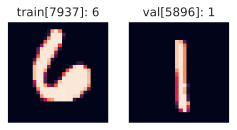

In [8]:
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

Создайте генераторы батчей.

In [9]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [11]:
cnn_0 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2704, out_features=10),
).to(device)

cnn_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=800, out_features=10),
).to(device)

cnn_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2704, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=800, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=10),
).to(device)

cnn_models = [cnn_0, cnn_1, cnn_2, cnn_3, cnn_4, cnn_5]

Напечатаем число параметров:

In [12]:
for i in range(len(cnn_models)):
    print(f"Модель {i + 1}:")
    summary_str = str(summary(cnn_models[i], input_size=(1, 1, 28, 28)))
    start = summary_str.find("Total params:")
    end = summary_str.find("\n", start)
    total_params = summary_str[start:end]
    print(total_params)

Модель 1:
Total params: 27,210
Модель 2:
Total params: 12,810
Модель 3:
Total params: 695,210
Модель 4:
Total params: 212,426
Модель 5:
Total params: 42,506
Модель 6:
Total params: 23,946


Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

Определим функции для обучения (из занятия):

In [13]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

Осталось обучить:

In [14]:
criterion = nn.CrossEntropyLoss()

history = [0] * len(cnn_models)
for i in range(len(cnn_models)):
    optimizer = torch.optim.Adam(cnn_models[i].parameters())
    history[i] = train(
    cnn_models[i], criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=10
    )

Epoch 10 of 10 took 21.321 s
  training loss: 	0.031673
  validation loss: 	0.054541
  training accuracy: 			98.97 %
  validation accuracy: 			98.51 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

Используем следующую функцию для визуализации (из занятия):

In [83]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colormap = plt.cm.get_cmap("viridis", len(histories))
    colors = [colormap(i) for i in range(len(histories))]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3)
        axs[i].legend(dummy_lines, ["train", "val"])
        axs[i].add_artist(legend)
    plt.show()

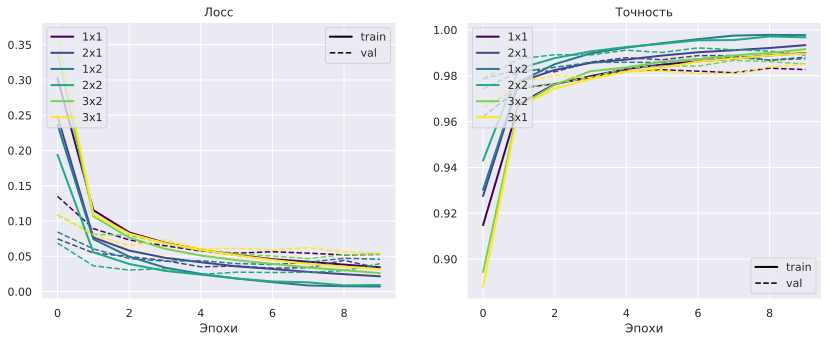

In [81]:
plot_histories(history, ["1x1", "2x1", "1x2", "2x2", "3x2", "3x1"])

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:** Как видно из графиков, сначала добавление слоёв улучшает точность нейросети, далее она чуть ухудшается. Оптимальное значение это сеть 2x2 - два сверточных и два линейных слоя. При этом на всех моделях переобучение наступает уже на ~4й эпохе, а время переобучения несильно зависит от выборы слоев. Само обучение на train выборке чуть быстрее при более оптимальном выборе слоев (в смысле требуется меньшее число эпох). Большее по времени обучение происходит на моделях с большим числом слоев (из-за большего числа параметров).

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

Возьмем сеть 2x2 и будем варьировать значения ядер.

In [17]:
cnn_kernel_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_kernel_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=800, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_kernel_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=800, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_kernel_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_kernel_models = [cnn_kernel_1, cnn_kernel_2, cnn_kernel_3, cnn_kernel_4]

Обучим:

In [18]:
criterion = nn.CrossEntropyLoss()

history_kernel = [0] * len(cnn_kernel_models)
for i in range(len(cnn_kernel_models)):
    optimizer = torch.optim.Adam(cnn_kernel_models[i].parameters())
    history_kernel[i] = train(
    cnn_models[i], criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=5
    )

Epoch 5 of 5 took 18.048 s
  training loss: 	0.009444
  validation loss: 	0.039492
  training accuracy: 			99.68 %
  validation accuracy: 			98.90 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

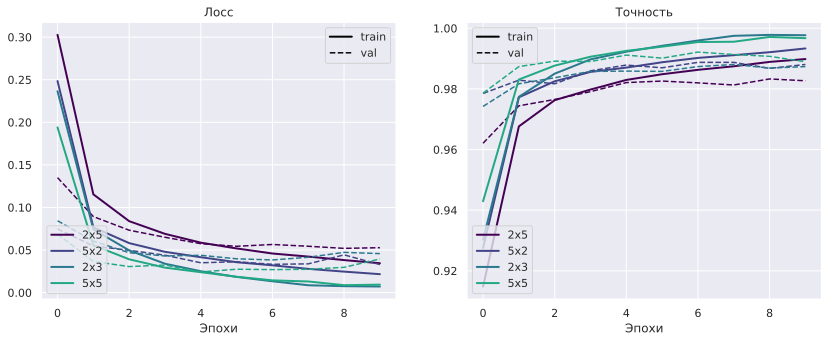

In [84]:
plot_histories(history, ["2x5", "5x2", "2x3", "5x5"])

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:** Увеличение размера ядра улучшило качество обучения (возможно, это связано с тем, что так нейросеть видит больше особенностей картинки), при этом время обучение сильно не изменяется, а переобучение происходит на ~4 эпохе. Скорость обучения на train выборке чуть больше у более оптимального размера ядер (2x3 и 5x5) (в смысле требуемого числа эпох).

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [85]:
model = cnn_models[3]

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

0: 0.991  1: 0.998  2: 0.985  3: 0.990  4: 0.982  5: 0.989  6: 0.985  7: 0.982  8: 0.998  9: 0.987


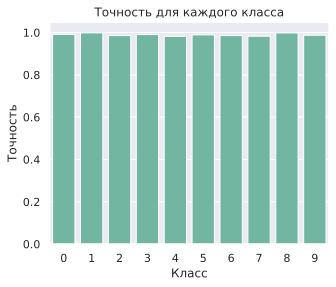

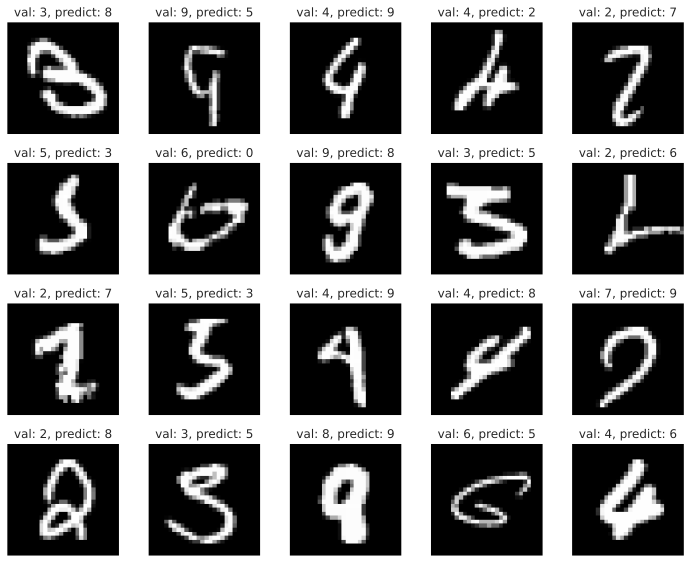

In [87]:
accuracity = [0] * 10

with torch.no_grad():
    
    val_all_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    
    x, y = next(iter(val_all_dataloader))
    
    logits = model(x)

    y_pred = logits.max(1)[1].detach().cpu().numpy()
    y = y.cpu().numpy()
    
    accuracity = [np.mean(y[y == i] == y_pred[y == i]) for i in range(10)]

    print('  '.join([f'{i}: {acc:.3f}' for i, acc in enumerate(accuracity)]))

    plt.figure(figsize=(5, 4))
    sns.barplot(x=range(10), y=accuracity)
    
    plt.xlabel('Класс')
    plt.ylabel('Точность')
    plt.title('Точность для каждого класса')

    plt.show()

    incorrect_indices = np.where(y != y_pred)[False]


plt.figure(figsize=(10, 8))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    img, label = val_dataset[incorrect_indices[i]]
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.title(f"val: {label}, predict: {y_pred[incorrect_indices[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

**Ответ:** Как видно, лучшая нейросеть примерно одинаково хорошо предсказывает каждую из цифр. Она ошибается, когда в исследуемой цифре есть паттерны, похожие на другие цифры. При этом в датасете присутствует небольшое число сложно написанных цифр, и на них чаще ошибается модель.

**Вывод по всей задаче:** В целом, довольно простая сверточная нейросеть с несколькими слоями распознает написанную цифру с точностью около 98.9%. При этом её обучение заняло всего пару минут, но мы использовали значительный датасет (70.000 картинок), варьирование параметров (число слоев и размер ядер) влияет на точность порядка +-0.3%. На ~4 эпохе происходит переобучение модели.

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

Функции для запуска и визуализации

In [24]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

def visualize_images(content_image, style_image, result_image, path="data/ALL/"):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param result_image: имя файла картинки результата
    :param path: путь к папке, в которой все лежит
    """
    plt.figure(figsize=(13, 3))
    names = [content_image, result_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread(path + names[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

Осталось сгенерировать и визуализировать:

/home/ubaca/Projects/Jupyter/DataAnalysis/Task5/Neural-Style-Transfer


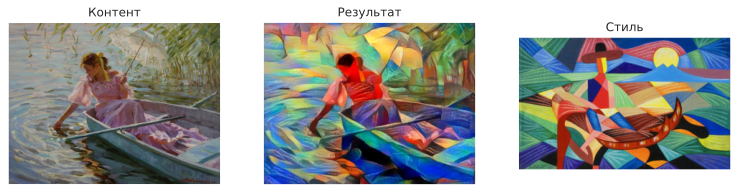

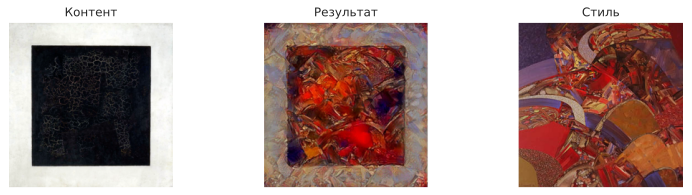

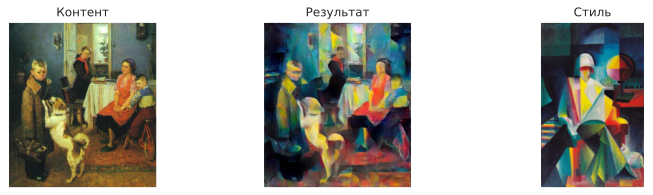

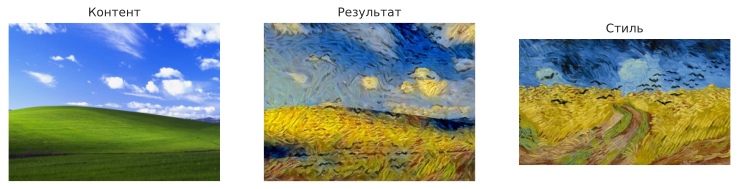

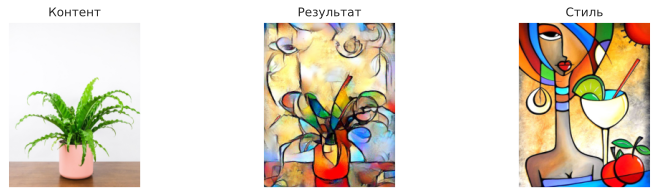

In [28]:
%cd Neural-Style-Transfer
for i in range(5):
    visualize_images("content_" + str(i + 1) + ".png",
                     "style_" + str(i + 1) + ".png",
                     "result_" + str(i + 1) + ".jpg")

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

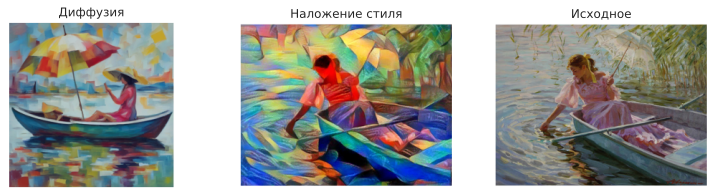

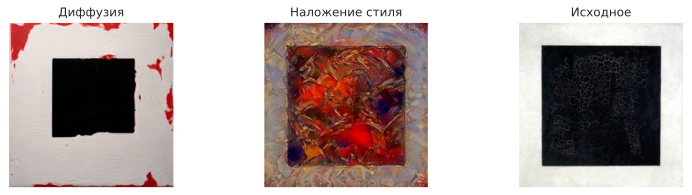

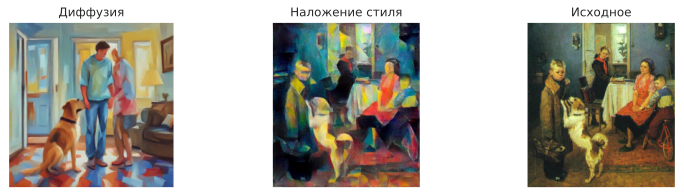

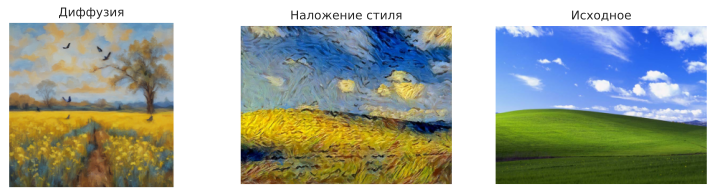

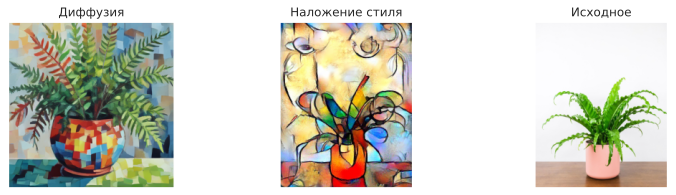

In [29]:
for i in range(5):
    plt.figure(figsize=(13, 3))
    names = ["diff_" + str(i + 1) + ".png", 
             "result_" + str(i + 1) + ".jpg",
             "content_" + str(i + 1) + ".png"]
    titles = ["Диффузия", "Наложение стиля", "Исходное"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/ALL/" + names[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

**Вывод:**
Мы смогли перенести стиль на картинку, а такого же эффекта от диффузионной модели достигнуть не получится, потому что из самого промта модель не сможет понять на какую именно картинку требуется перенос стиля. Тем не менее, эта модель хорошо умеет генерировать картинки по нужному запросу.